In [10]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define Rod_ih
Eh_rev = -32*mV
Vhalf_h = -82*mV
gh_bar = 2.5*msiemens*cm**-2
Sh = -5.33*mV
aoh = 1*Hz

eqs_h = '''
ah = aoh*exp( (V-Vhalf_h)/(2*Sh) ) : Hz
bh = aoh*exp( -(V-Vhalf_h)/(2*Sh) ) : Hz
tauh = 1/(ah+bh) : second
infh = ah*tauh : 1

dnh/dt = (infh-nh)/tauh : 1
gh = gh_bar * nh : siemens / metre**2
Ih = gh * (V-Eh_rev) : amp / metre**2
'''

In [5]:
# Define Rod_leak
glbar = 0.52*msiemens*cm**-2
El_rev = -74*mV

eqs_leak = '''
Ileak = glbar * (V-El_rev) : amp / metre**2
'''

In [33]:
# Photocurrent parameters
Idark = -40*pA
Tau1 = 50*ms
Tau2 = 450*ms
Tau3 = 800*ms
RodB = 3800*ms

eqs_input = '''
# input photocurrent
Ip = Idark + A*( 32*(1-exp(-t/Tau1)) - 33*(1/(1+exp(-(t-RodB)/Tau2))) + (1-exp(-t/Tau3)))/33: amp
A : amp
'''

In [97]:
# Define Rod_Kv
EKv_rev = -80*mV # Was -74mV
gKv_bar = 10*msiemens*cm**-2

eqs_Kv = '''
gKv = gKv_bar * (mKv**4) : siemens / metre**2
IKv = gKv * (V-EKv_rev) : amp / metre**2
dmKv/dt = (infmKv - mKv)/taumKv : 1

alphamKv = 0.005 * (20-V/mV)/(exp((20-V/mV)/22)-1)/ms : Hz
betamKv = 1/16 * exp(-V/mV/80)/ms : Hz

taumKv = 1/(alphamKv+betamKv) : second
infmKv = alphamKv * taumKv : 1
'''

In [98]:
# Define Rod_Kx
EKx_rev = -74*mV
gKx_bar = 1.04*msiemens*cm**-2
Vhalf_Kx = -49.9*mV
SKx = 5.7*mV
aoKx = 0.66*Hz

eqs_Kx = '''
aKx = aoKx*exp( (V-Vhalf_Kx)/(2*SKx) ) : Hz
bKx = aoKx*exp( -(V-Vhalf_Kx)/(2*SKx) ) : Hz
tauKx = 1/(aKx+bKx) : second
infKx = aKx*tauKx : 1

dnKx/dt = (infKx-nKx)/tauKx : 1

gKx = gKx_bar * nKx : siemens / metre**2
IKx = gKx * (V-EKx_rev) : amp / metre**2
'''

In [99]:
# Morphology params
length = 10/np.pi*umeter
diam = 10*umetre

# Cylinder area = 2*pi*radius*length + 2*pi*radius^2
cell_area = np.pi*diam*length + 2*np.pi*diam**2/4
print(cell_area)
membrane_capacitance = 30*pfarad/cell_area
Ra = 200*ohm*cm

257.07963268 um^2


In [114]:
# Define Rod_Ca
gCabar = 4*msiemens*cm**-2
ECa_rev = 40*mV
aomCa = 100*Hz
bomCa = 100*Hz
gammaohCa = 10*Hz
deltaohCa = 10*Hz

VhalfCam = -10*mV
VhalfCah = 11*mV

SCam = 6*mV
SCah = 9*mV

eqs_Ca = '''
alphamCa = 0.001*aomCa*exp( (V-VhalfCam)/(2*SCam) ) : Hz
betamCa = 0.001*bomCa*exp( -(V-VhalfCam)/(2*SCam) ) : Hz
gammahCa = 0.001*gammaohCa*exp( (V-VhalfCah)/(2*SCah) ) : Hz
deltahCa = 0.001*deltaohCa*exp( -(V-VhalfCah)/(2*SCah) ) : Hz

taumCa = 1/(alphamCa+betamCa) : second
infmCa = alphamCa/(alphamCa+betamCa) : 1

tauhCa = 1/(gammahCa+deltahCa) : second
infhCa = deltahCa/(gammahCa+deltahCa) : 1

dmCa/dt = (infmCa-mCa)/taumCa : 1
dhCa/dt = (infhCa-hCa)/tauhCa : 1

gCa = gCabar * mCa * hCa : siemens / metre**2
ICa = gCa * (V-ECa_rev) : amp / metre**2
'''

In [117]:
# Rod calcium dynamics model

depth = 10*umeter # Depth of shell
taur = 20*ms # Rate of calcium removal
Cainf = 5e-5*mM
Cao = 2*mM
entryF = 1
FARADAY = 96485.33289 * coulomb / mole

# drive_channel =  - (10000) * iCa / (2 * FARADAY * depth)
# 	if (drive_channel <= 0.) { drive_channel = 0.  }   : cannot pump inward 
         
# 	:ca' = drive_channel + (cainf-ca)/taur
#         :Ca' = drive_channel/18 + (Cainf -Ca)/taur*7
# 	Ca' = entryF*drive_channel/2 + (Cainf-Ca)/taur
	
#         Cai = Ca
# 	Cao=2 :mM
eqs_Cadyn = '''

Cai = Ca :mM
Cao = 2*mM :mM
drive_channel =  - (10000) * ICa / (2 * FARADAY * depth) :mM/second

dCa/dt = entryF*drive_channel/2 + (Cainf-Ca)/taur :mM

'''

In [123]:
# Define rod calcium activated chloride channel
ECl_rev = -20*mV
gCl_bar = 1.3*msiemens*cm**-2
Clh = 1.5*umolar

eqs_CaCl = '''
Cas = Cai*1000 :mM
mCl = 1/(  1+(Clh/Cas)**4 ) :1
gCl = gCl_bar * mCl :siemens / metre**2
ICl = gCl * (V-ECl_rev) :amp / metre**2
'''

In [141]:
# Define rod calcium activated potassium channel
EKCa_rev = -80*mV
gKCa_bar = 5*msiemens*cm**-2
Cahalf = 0.32*umolar

eqs_KCa = '''
#Cas = Cai*1000 :mmolar
#mKcaCa = 1/(1+(Cahalf/Cas)**4 ) :1
mKcaCa = Cai/(Cai+12*mmolar) :1
#gKCa = gKCa_bar * mKcaCa**4 :siemens / metre**2
gKCa = gKCa_bar * mKcaCa :siemens / metre**2
IKCa = gKCa * (V-EKCa_rev) :amp / metre**2
'''

In [190]:
# Arrays to store output V and Ip
n_timepoints = 810
n_conditions = 5
arr_V = np.zeros((n_conditions, n_timepoints))
arr_Ip = np.zeros((n_conditions, n_timepoints))

In [191]:
eqs_total = '''
# Transmembrane current
Im = 0*amp/metre**2 : amp / metre**2

#dV/dt = -(Ih + IKv + IKx + Ileak + ICa + ICl + IKCa + Ip/(cell_area)) / Cm : volt
dV/dt = -(Ih + IKv + IKx + ICa + ICl + IKCa + Ileak + Ip/(cell_area)) / Cm : volt
'''
eqs = eqs_input + eqs_total + eqs_h + eqs_leak + eqs_Kv + \
    eqs_Kx + eqs_Ca + eqs_Cadyn + eqs_CaCl + eqs_KCa

In [208]:
amps = [1, 10, 20, 30, 40]
for idx, amp in enumerate(amps):
    # Set up simulation
    defaultclock.dt = 1*ms
    start_scope()

    morpho = Cylinder(diameter=diam, n=1, length=length)
    neuron = SpatialNeuron(morphology=morpho, model=eqs, Cm=membrane_capacitance, Ri=Ra, method='euler')
    # Monitor voltage and Ip
    M = StateMonitor(neuron, ['V', 'Ip', 'Ih', 'Ileak',
                            'IKv', 'IKx', 'ICa', 'Ca', 
                            'ICl', 'IKCa'],
                    record=True, dt=10*ms)
    neuron.Ca = Cainf
    neuron.V = -44*mV
    neuron.A = 0*pA
    # Initialize gating variables
    # run(1*ms)
    neuron.nKx = neuron.infKx[:][0]
    neuron.mKv = neuron.infmKv[:][0]
    neuron.mCa = neuron.infmCa[:][0]
    neuron.hCa = neuron.infhCa[:][0]
    neuron.nh = neuron.infh[:][0]

    run(100*ms)
    neuron.A = amp*pA
    run(6000*ms)
    neuron.A = 0*pA
    run(2000*ms)
    arr_V[idx, :] = M.V[0]/mV
    arr_Ip[idx, :] = M.Ip[0]/pA
    # plot(M.t/ms, M.V[0]/mV)
    # xlabel('Time (ms)')
    # ylabel('Voltage (mV)')

    # plt.figure()
    # plot(M2.t/ms, M2.Ip[0]/pA)
    # xlabel('Time (ms)')
    # ylabel('Photocurrent (pA)')

Text(0, 0.5, 'Voltage (mV)')

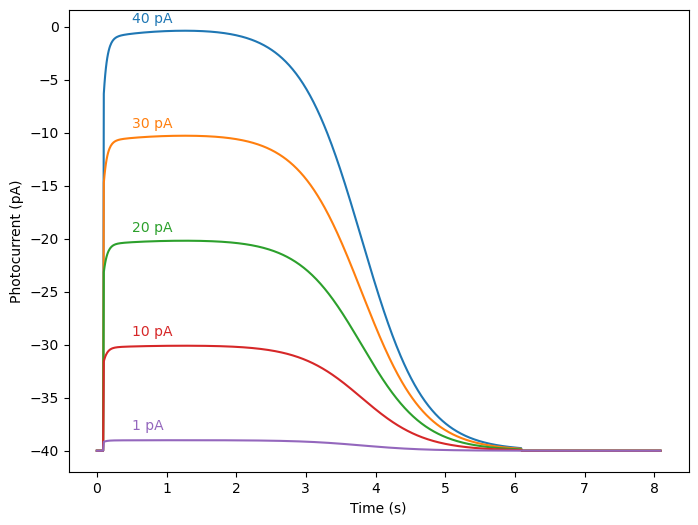

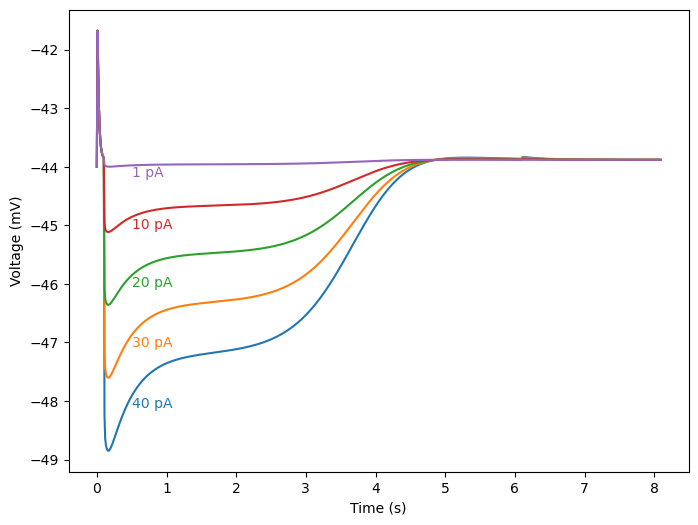

In [207]:
# Plot Ip traces
f, ax = plt.subplots(1, 1, figsize=(8, 6))
for idx, amp in enumerate(amps):
    ax.plot(M.t/second, arr_Ip[idx, :], label='{} pA'.format(amp))

    # Colored text for each trace
    y_pos = arr_Ip[idx, 50]
    ax.text(0.5, y_pos+1, '{} pA'.format(amp), color='C{}'.format(idx))
ax.set_ylabel('Photocurrent (pA)')
ax.set_xlabel('Time (s)')

# Plot voltage traces
f, ax = plt.subplots(1, 1, figsize=(8, 6))
for idx, amp in enumerate(amps):
    ax.plot(M.t/second, arr_V[idx, :], label='{} pA'.format(amp))

    # Colored text for each trace
    y_pos = arr_V[idx, 50]
    ax.text(0.5, y_pos-0.2, '{} pA'.format(amp), color='C{}'.format(idx))
# plt.legend(loc=(1.05, 0.5))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (mV)')

Text(0.5, 0, 'Time (s)')

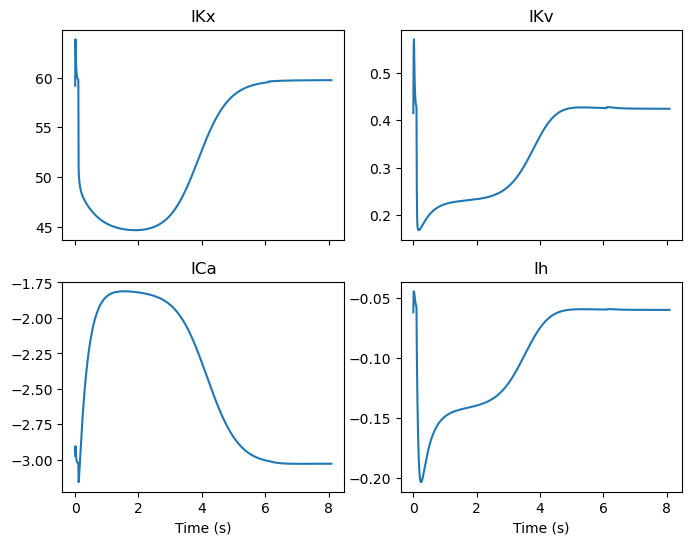

In [218]:
# Plot IKx, Ih, IKv, ICa in separate figures
f, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
axs = axs.flatten()
for idx, label in enumerate(['IKx', 'IKv', 'ICa', 'Ih']):
    trace = getattr(M, label)[0]*cell_area/pA
    axs[idx].plot(M.t/second, trace)
    axs[idx].set_title(label)
axs[idx-1].set_xlabel('Time (s)')
axs[idx].set_xlabel('Time (s)')

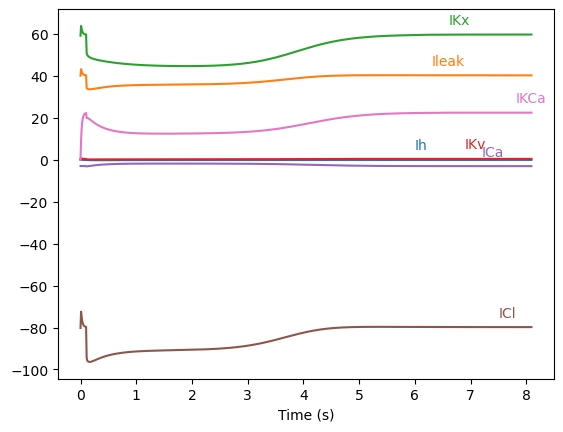

In [211]:
plt.plot(M.t/second, M.Ih[0]*cell_area/pA, label='h')
plt.plot(M.t/second, M.Ileak[0]*cell_area/pA, label='leak')
plt.plot(M.t/second, M.IKx[0]*cell_area/pA, label='Kx')
plt.plot(M.t/second, M.IKv[0]*cell_area/pA, label='Kv')
plt.plot(M.t/second, M.ICa[0]*cell_area/pA, label='Ca')
# plt.plot(M.t/second, M.Ca[0]/mM, label='Ca')
plt.plot(M.t/second, M.ICl[0]*cell_area/pA, label='Cl')
plt.plot(M.t/second, M.IKCa[0]*cell_area/pA, label='KCa')
plt.xlabel('Time (s)')
# plt.ylabel('Ion Channel currents')
# plt.legend(loc=(1.05, 0.5))

# Label traces with their channel names
for i, label in enumerate(('Ih', 'Ileak', 'IKx', 'IKv', 'ICa', 'ICl', 'IKCa')):
    y_pos = getattr(M, label)[0][-1]*cell_area/pA
    plt.text(6+i*0.3, y_pos+5, label, color=f'C{i}')